In [36]:
# !pip install transformers
# !pip install transformers[torch]
# !pip install accelerate -U
import transformers

print(transformers.__version__)

4.33.2


In [37]:

import os
import torch
import pandas as pd
import transformers
from transformers import TrainingArguments
from transformers import BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [38]:
from transformers import pipeline

In [39]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [40]:
ROOT_DIR = '../content/7allV03.csv'
df_org = pd.read_csv(ROOT_DIR)
df_org = df_org.sample(frac = 1.0, random_state = 42)
df_org.head()

,category,text
51,siyaset,paris teki infaz imralı ile başlayan sürece b...
289,siyaset,kılıçdaroğlu tekke tartışması tamamen yapay c...
677,siyaset,kamalak tan 29 ekim cumhuriyet_bayramı mesajı...
1005,dunya,sandy den sonra abd kabusu yaşıyor sandy kası...
367,siyaset,ab başkentine islam üssü diyanet_işleri_başka...


In [41]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['siyaset', 'dunya', 'ekonomi']

In [42]:
for key, value in enumerate(labels):
  print(value)

siyaset
dunya
ekonomi


In [43]:
NUM_LABELS = len(labels)

id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}
label2id

{'siyaset': 0, 'dunya': 1, 'ekonomi': 2}

In [44]:
id2label

{0: 'siyaset', 1: 'dunya', 2: 'ekonomi'}

In [45]:
df_org.head()

,category,text
51,siyaset,paris teki infaz imralı ile başlayan sürece b...
289,siyaset,kılıçdaroğlu tekke tartışması tamamen yapay c...
677,siyaset,kamalak tan 29 ekim cumhuriyet_bayramı mesajı...
1005,dunya,sandy den sonra abd kabusu yaşıyor sandy kası...
367,siyaset,ab başkentine islam üssü diyanet_işleri_başka...


In [46]:
df_org['labels'] = df_org.category.map(lambda x: label2id[x.strip()])
df_org.head()

,category,text,labels
51,siyaset,paris teki infaz imralı ile başlayan sürece b...,0
289,siyaset,kılıçdaroğlu tekke tartışması tamamen yapay c...,0
677,siyaset,kamalak tan 29 ekim cumhuriyet_bayramı mesajı...,0
1005,dunya,sandy den sonra abd kabusu yaşıyor sandy kası...,1
367,siyaset,ab başkentine islam üssü diyanet_işleri_başka...,0


<Axes: ylabel='category'>

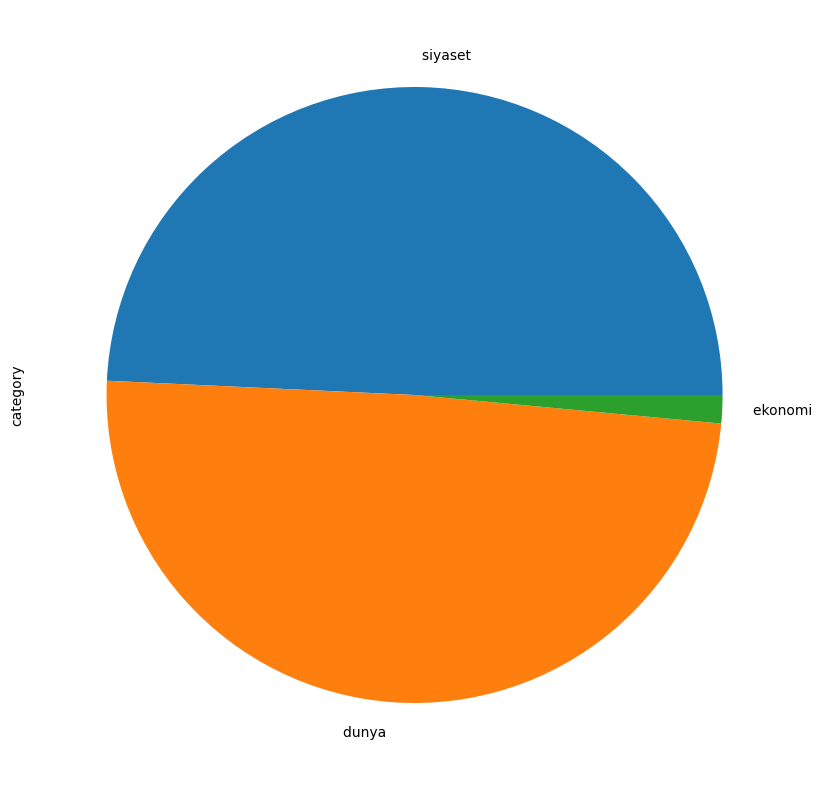

In [47]:
df_org.category.value_counts().plot(kind ='pie', figsize = (10,10))

In [48]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length = 512)
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels = NUM_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [50]:
SIZE = df_org.shape[0]

train_texts = list(df_org.text[:SIZE//2])

val_texts = list(df_org.text[SIZE//2:(3*SIZE)//4])

test_texts = list(df_org.text[(3*SIZE)//4:])

train_labels = list(df_org.labels[:SIZE//2])

val_labels = list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels = list(df_org.labels[(3*SIZE)//4:])

In [51]:
len(train_texts)


710

In [52]:
len(train_texts), len(val_texts), len(test_texts)

(710, 355, 356)

In [53]:
train_encodings = tokenizer(train_texts, truncation = True, padding = True)
val_encodings = tokenizer(val_texts, truncation = True, padding = True)
test_encodings = tokenizer(test_texts, truncation = True, padding = True)

In [54]:
class DataLoader(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])

    return item
  def __len__(self):
    return len(self.labels)


In [55]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataloader = DataLoader(test_encodings, test_labels)

In [56]:
from transformers import TrainingArguments, Trainer, AutoModelForCausalLM

In [57]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'macro')

  acc = accuracy_score(labels, preds)
  return {
      'Accuracy': acc,
      'F1': f1,
      'Precision': precision,
      'Recall': recall
  }

In [58]:
from transformers import TrainingArguments, Trainer, training_args

In [59]:
training_args = TrainingArguments(
    output_dir = './TTC4900Model',
    do_train = True,
    do_eval = True,
    num_train_epochs = 1,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 32,

    warmup_steps = 100,
    weight_decay = 0.01,
    logging_strategy = 'steps',
    logging_dir = './multi_class_logs',
    logging_steps = 50,
    evaluation_strategy = 'steps',
    eval_steps = 50,
    save_strategy = "steps",
    fp16 = True,
    load_best_model_at_end = True
)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataloader,
    eval_dataset = val_dataloader,
    compute_metrics = compute_metrics,

)

In [60]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=45, training_loss=0.8177258809407552, metrics={'train_runtime': 25.0746, 'train_samples_per_second': 28.316, 'train_steps_per_second': 1.795, 'total_flos': 186810526586880.0, 'train_loss': 0.8177258809407552, 'epoch': 1.0})

In [61]:
q = [trainer.evaluate(eval_dataset = df_org) for df_org in [train_dataloader, val_dataloader, test_dataloader]]
pd.DataFrame(q, index= ['train', "val", "test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.494874,0.929577,0.625461,0.621213,0.630926
val,0.501512,0.904225,0.606848,0.606022,0.610659
test,0.501815,0.901685,0.603645,0.602123,0.607822


In [62]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [68]:
def predict(text):
  # to("cuda" if torch.cuda.is_available() else "cpu")
  inputs = tokenizer(text, padding = True, truncation = True, max_length = 512, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")
  # get modeloutput(logits)
  outputs = model(**inputs)
  probs = outputs[0].softmax(1)

  pred_label_idx = probs.argmax()
  pred_label = model.config.id2label[pred_label_idx.item()]
  return probs, pred_label_idx, pred_label

In [69]:
text = "Makine öğrenimi kendiliğinden daha da otomatik hale geliyor."
predict(text)

(tensor([[0.4471, 0.3507, 0.2023]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'LABEL_0')

Save Model for Inference

In [70]:
model_path = "turkish_text_clsfn_model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('turkish_text_clsfn_model/tokenizer_config.json',
 'turkish_text_clsfn_model/special_tokens_map.json',
 'turkish_text_clsfn_model/vocab.txt',
 'turkish_text_clsfn_model/added_tokens.json',
 'turkish_text_clsfn_model/tokenizer.json')

Reload Saved Model for Inference

In [71]:
model_path = "turkish_text_clsfn_model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("sentiment-analysis", model = model, tokenizer = tokenizer)


In [72]:
nlp("Bugün hava çok güzel, dışarıda yemek istiyorum.")

[{'label': 'LABEL_0', 'score': 0.5173903703689575}]